# Лабораторная работа 1: Регрессионный анализ данных о песнях

Цель работы: Провести полный цикл анализа данных и построения регрессионных моделей для предсказания популярности песен на основе их аудио-характеристик

Задачи:
- Провести исследовательский анализ данных
- Выполнить предобработку данных (нормализация, кодирование категориальных переменных)
- Построить регрессионные модели до и после устранения мультиколлинеарности
- Оценить качество моделей с помощью метрик RMSE, R², MAPE
- Применить метод главных компонент (PCA) для снижения размерности
- Сравнить результаты моделей до и после применения PCA


In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


Описание датасета

В данном разделе представлен первичный анализ датасета, включающий:
- Общую информацию о структуре данных
- Анализ пропущенных значений
- Визуализацию распределения признаков
- Построение корреляционной матрицы


In [2]:
# Загрузка данных
df = pd.read_csv('song_data.csv')

# Первичный анализ данных
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о датасете:")
print(df.info())
print("\nСтатистическое описание:")
print(df.describe())


Размер датасета: (18835, 15)

Первые 5 строк:
                    song_name  song_popularity  song_duration_ms  \
0  Boulevard of Broken Dreams               73            262333   
1                  In The End               66            216933   
2           Seven Nation Army               76            231733   
3                  By The Way               74            216933   
4           How You Remind Me               56            223826   

   acousticness  danceability  energy  instrumentalness  key  liveness  \
0      0.005520         0.496   0.682          0.000029    8    0.0589   
1      0.010300         0.542   0.853          0.000000    3    0.1080   
2      0.008170         0.737   0.463          0.447000    0    0.2550   
3      0.026400         0.451   0.970          0.003550    0    0.1020   
4      0.000954         0.447   0.766          0.000000   10    0.1130   

   loudness  audio_mode  speechiness    tempo  time_signature  audio_valence  
0    -4.095          

In [4]:
# Анализ пропущенных значений
print("Пропущенные значения по столбцам:")
missing_values = df.isnull().sum()
missing_count = missing_values[missing_values > 0]
print(missing_count)

# Визуализация пропущенных значений (только если они есть)
if len(missing_count) > 0:
    plt.figure(figsize=(12, 6))
    missing_count.plot(kind='bar')
    plt.title('Количество пропущенных значений по столбцам')
    plt.xlabel('Столбцы')
    plt.ylabel('Количество пропущенных значений')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("\nПропущенных значений не обнаружено. Все данные заполнены.")


Пропущенные значения по столбцам:
Series([], dtype: int64)

Пропущенных значений не обнаружено. Все данные заполнены.


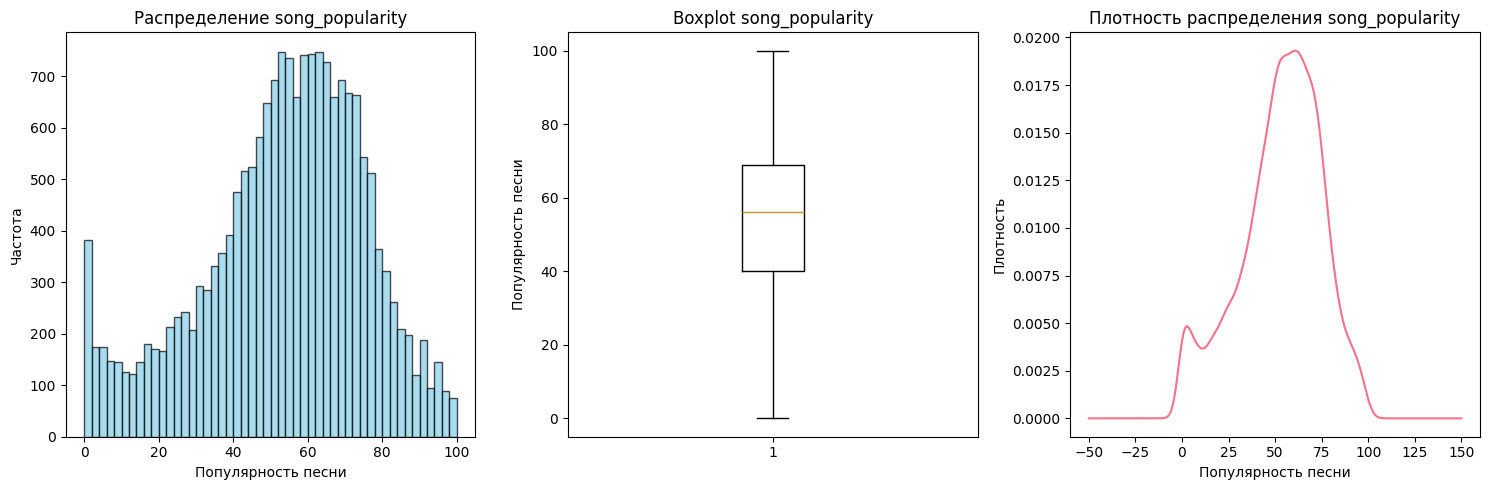

Статистики для song_popularity:
Среднее: 52.99
Медиана: 56.00
Стандартное отклонение: 21.91
Минимум: 0
Максимум: 100


In [ ]:
# Визуализация распределения целевой переменной (song_popularity)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['song_popularity'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Распределение song_popularity')
plt.xlabel('Популярность песни')
plt.ylabel('Частота')

plt.subplot(1, 3, 2)
plt.boxplot(df['song_popularity'])
plt.title('Boxplot song_popularity')
plt.ylabel('Популярность песни')

plt.subplot(1, 3, 3)
df['song_popularity'].plot(kind='density')
plt.title('Плотность распределения song_popularity')
plt.xlabel('Популярность песни')
plt.ylabel('Плотность')

plt.tight_layout()
plt.show()

print(f"Статистики для song_popularity:")
print(f"Среднее: {df['song_popularity'].mean():.2f}")
print(f"Медиана: {df['song_popularity'].median():.2f}")
print(f"Стандартное отклонение: {df['song_popularity'].std():.2f}")
print(f"Минимум: {df['song_popularity'].min()}")
print(f"Максимум: {df['song_popularity'].max()}")


## Подготовка данных

Здесь мы выполняем предобработку данных:
- Удаление пропущенных значений
- Кодирование категориальных переменных
- Нормализация признаков
- Разделение выборки на обучающую и тестовую (train/test)


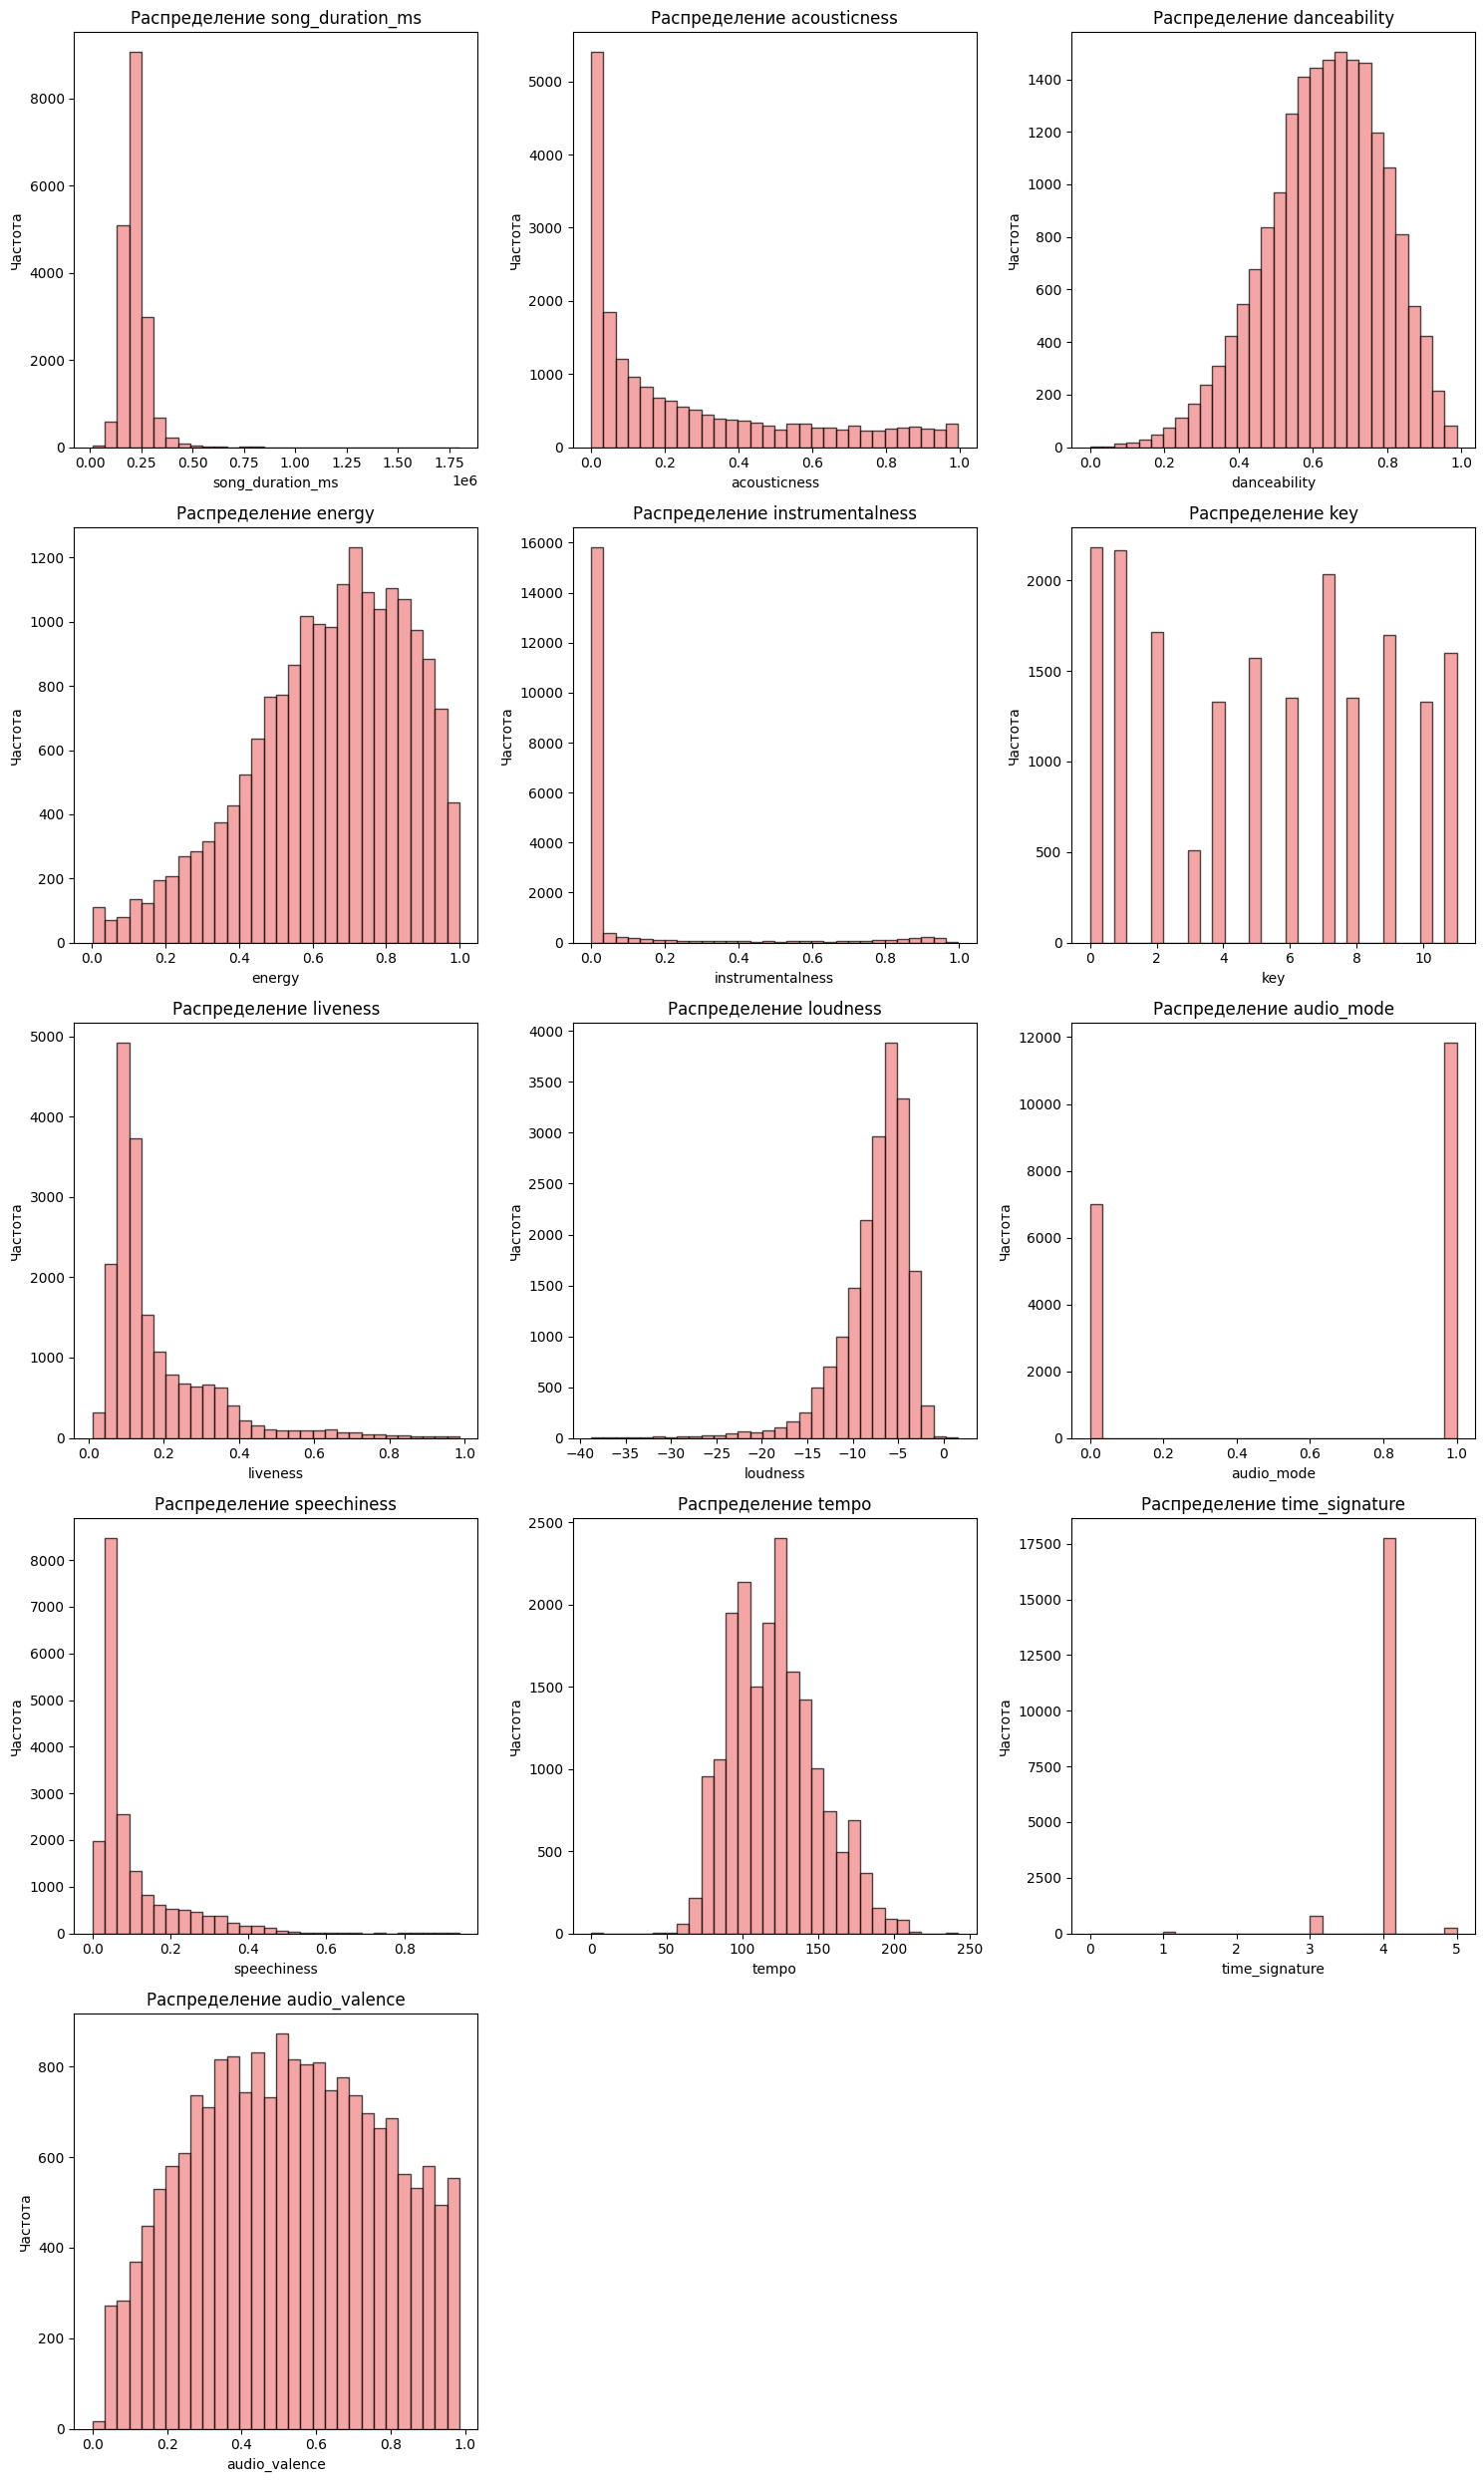

In [ ]:
# Визуализация распределения числовых признаков
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
if 'song_popularity' in numeric_columns:
    numeric_columns.remove('song_popularity')

# Создаем subplot для всех числовых признаков
n_cols = 3
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

plt.figure(figsize=(15, 5 * n_rows))
for i, col in enumerate(numeric_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(df[col].dropna(), bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()


In [ ]:
# Предобработка данных
print("Предобработка данных...")

# Создаем копию датасета для предобработки
df_processed = df.copy()

# 1. Удаление пропущенных значений
print(f"Размер до удаления пропущенных значений: {df_processed.shape}")
df_processed = df_processed.dropna()
print(f"Размер после удаления пропущенных значений: {df_processed.shape}")

# 2. Анализ категориальных переменных
categorical_columns = df_processed.select_dtypes(include=['object']).columns.tolist()
print(f"\nКатегориальные переменные: {categorical_columns}")

# Показываем уникальные значения для каждой категориальной переменной
for col in categorical_columns:
    unique_values = df_processed[col].nunique()
    print(f"{col}: {unique_values} уникальных значений")
    if unique_values <= 10:  # Показываем значения только если их немного
        print(f"  Значения: {df_processed[col].unique()}")
    print()


Предобработка данных...
Размер до удаления пропущенных значений: (18835, 15)
Размер после удаления пропущенных значений: (18835, 15)

Категориальные переменные: ['song_name']
song_name: 13070 уникальных значений



### Корреляционный анализ

Строим матрицу корреляций для выявления взаимосвязей между признаками и целевой переменной. Далее проводим анализ мультиколлинеарности с помощью коэффициента инфляции дисперсии (VIF) для выявления взаимосвязанных признаков


In [ ]:
# Кодирование категориальных переменных (если необходимо)
df_encoded = df_processed.copy()

# Применяем Label Encoding для категориальных переменных
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"Закодирована переменная: {col}")

print(f"\nРазмер датасета после кодирования: {df_encoded.shape}")
print("\nПервые 5 строк после кодирования:")
print(df_encoded.head())


Закодирована переменная: song_name

Размер датасета после кодирования: (18835, 15)

Первые 5 строк после кодирования:
   song_name  song_popularity  song_duration_ms  acousticness  danceability  \
0       1561               73            262333      0.005520         0.496   
1       5541               66            216933      0.010300         0.542   
2       9638               76            231733      0.008170         0.737   
3       1760               74            216933      0.026400         0.451   
4       4988               56            223826      0.000954         0.447   

   energy  instrumentalness  key  liveness  loudness  audio_mode  speechiness  \
0   0.682          0.000029    8    0.0589    -4.095           1       0.0294   
1   0.853          0.000000    3    0.1080    -6.407           0       0.0498   
2   0.463          0.447000    0    0.2550    -7.828           1       0.0792   
3   0.970          0.003550    0    0.1020    -4.938           1       0.1070   
4 

In [ ]:
# Нормализация признаков
# Выбираем только числовые признаки для нормализации
numeric_features = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
if 'song_popularity' in numeric_features:
    numeric_features.remove('song_popularity')  # Не нормализуем целевую переменную

print(f"Признаки для нормализации: {numeric_features}")

# Применяем StandardScaler
scaler = StandardScaler()
df_normalized = df_encoded.copy()
df_normalized[numeric_features] = scaler.fit_transform(df_encoded[numeric_features])

print("\nСтатистики до нормализации:")
print(df_encoded[numeric_features].describe())
print("\nСтатистики после нормализации:")
print(df_normalized[numeric_features].describe())


Признаки для нормализации: ['song_name', 'song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode', 'speechiness', 'tempo', 'time_signature', 'audio_valence']

Статистики до нормализации:
         song_name  song_duration_ms  acousticness  danceability  \
count  18835.00000      1.883500e+04  18835.000000  18835.000000   
mean    6534.86095      2.182116e+05      0.258539      0.633348   
std     3771.67606      5.988754e+04      0.288719      0.156723   
min        0.00000      1.200000e+04      0.000001      0.000000   
25%     3298.00000      1.843395e+05      0.024100      0.533000   
50%     6557.00000      2.113060e+05      0.132000      0.645000   
75%     9792.50000      2.428440e+05      0.424000      0.748000   
max    13069.00000      1.799346e+06      0.996000      0.987000   

             energy  instrumentalness           key      liveness  \
count  18835.000000      18835.000000  18835.000000  18835.000

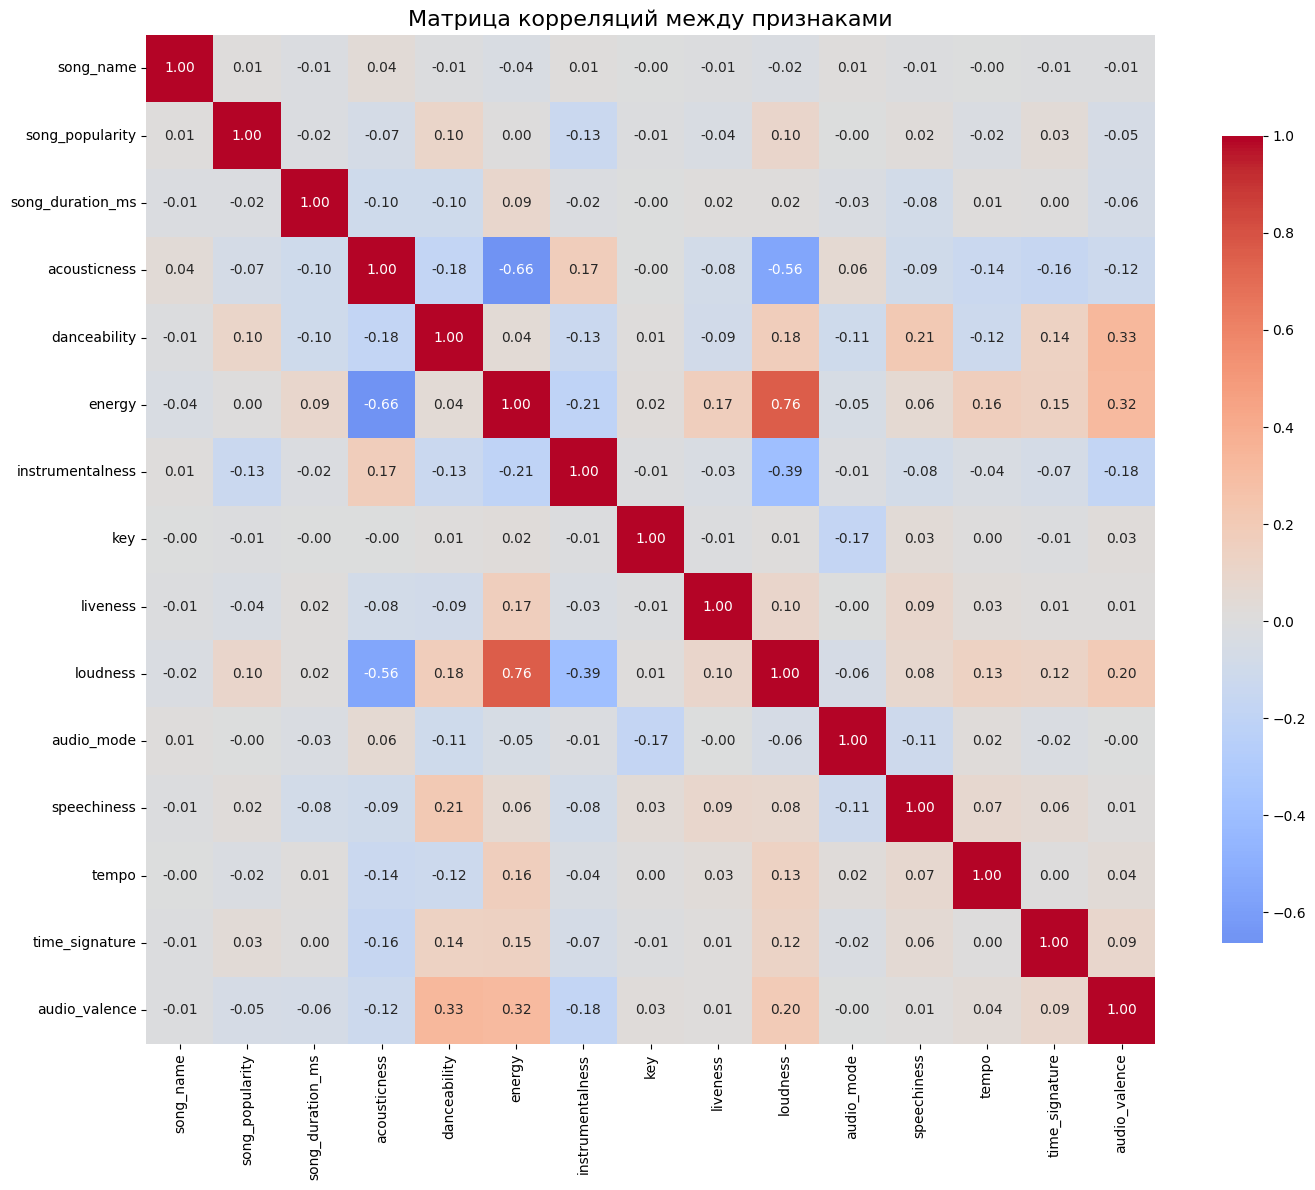

Корреляции с целевой переменной (song_popularity):
instrumentalness   -0.130907
danceability        0.104290
loudness            0.099442
acousticness       -0.065181
audio_valence      -0.052895
liveness           -0.038937
time_signature      0.034983
tempo              -0.022672
speechiness         0.021479
song_duration_ms   -0.018899
key                -0.013160
song_name           0.009364
audio_mode         -0.004969
energy              0.001365
Name: song_popularity, dtype: float64


In [ ]:
# Построение матрицы корреляций
plt.figure(figsize=(15, 12))

# Вычисляем корреляционную матрицу
correlation_matrix = df_normalized.corr()

# Создаем heatmap
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={'shrink': 0.8})

plt.title('Матрица корреляций между признаками', fontsize=16)
plt.tight_layout()
plt.show()

# Выводим корреляции с целевой переменной
target_correlations = correlation_matrix['song_popularity'].drop('song_popularity').sort_values(key=abs, ascending=False)
print("Корреляции с целевой переменной (song_popularity):")
print(target_correlations)


Сравнительная таблица метрик качества моделей до и после применения PCA

В данном разделе будут построены различные модели регрессии на исходных данных и рассчитаны метрики качества (RMSE, R², MAPE)
Будет примененён метод главных компонент (PCA) для снижения размерности данных. Построим график каменистой осыпи (scree plot) для определения оптимального количества компонент.
Повторно построим модели регрессии на данных после применения PCA и сравнение метрик с результатами, полученными до применения PCA.


In [ ]:
# Анализ мультиколлинеарности с помощью VIF
def calculate_vif(data):
    """Вычисляет VIF для всех признаков в датасете"""
    vif_data = pd.DataFrame()
    vif_data["Признак"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) 
                       for i in range(len(data.columns))]
    return vif_data

# Выбираем только числовые признаки для VIF (исключаем целевую переменную)
features_for_vif = df_normalized.select_dtypes(include=[np.number]).columns.tolist()
if 'song_popularity' in features_for_vif:
    features_for_vif.remove('song_popularity')

# Вычисляем VIF
vif_df = calculate_vif(df_normalized[features_for_vif])
vif_df = vif_df.sort_values('VIF', ascending=False)

print("VIF-коэффициенты для выявления мультиколлинеарности:")
print(vif_df)

# Интерпретация VIF
print("\nИнтерпретация VIF:")
print("VIF < 5: мультиколлинеарность отсутствует")
print("5 ≤ VIF < 10: умеренная мультиколлинеарность")
print("VIF ≥ 10: высокая мультиколлинеарность")

# Выделяем проблемные признаки
high_vif = vif_df[vif_df['VIF'] >= 10]
if len(high_vif) > 0:
    print(f"\nПризнаки с высокой мультиколлинеарностью (VIF ≥ 10):")
    print(high_vif)
else:
    print("\nПризнаков с высокой мультиколлинеарностью не обнаружено")


VIF-коэффициенты для выявления мультиколлинеарности:
             Признак       VIF
4             energy  3.727301
8           loudness  2.936798
2       acousticness  1.979313
3       danceability  1.430291
13     audio_valence  1.393417
5   instrumentalness  1.249068
10       speechiness  1.102124
11             tempo  1.064851
9         audio_mode  1.058183
7           liveness  1.052285
12    time_signature  1.045503
1   song_duration_ms  1.045097
6                key  1.032045
0          song_name  1.001993

Интерпретация VIF:
VIF < 5: мультиколлинеарность отсутствует
5 ≤ VIF < 10: умеренная мультиколлинеарность
VIF ≥ 10: высокая мультиколлинеарность

Признаков с высокой мультиколлинеарностью не обнаружено


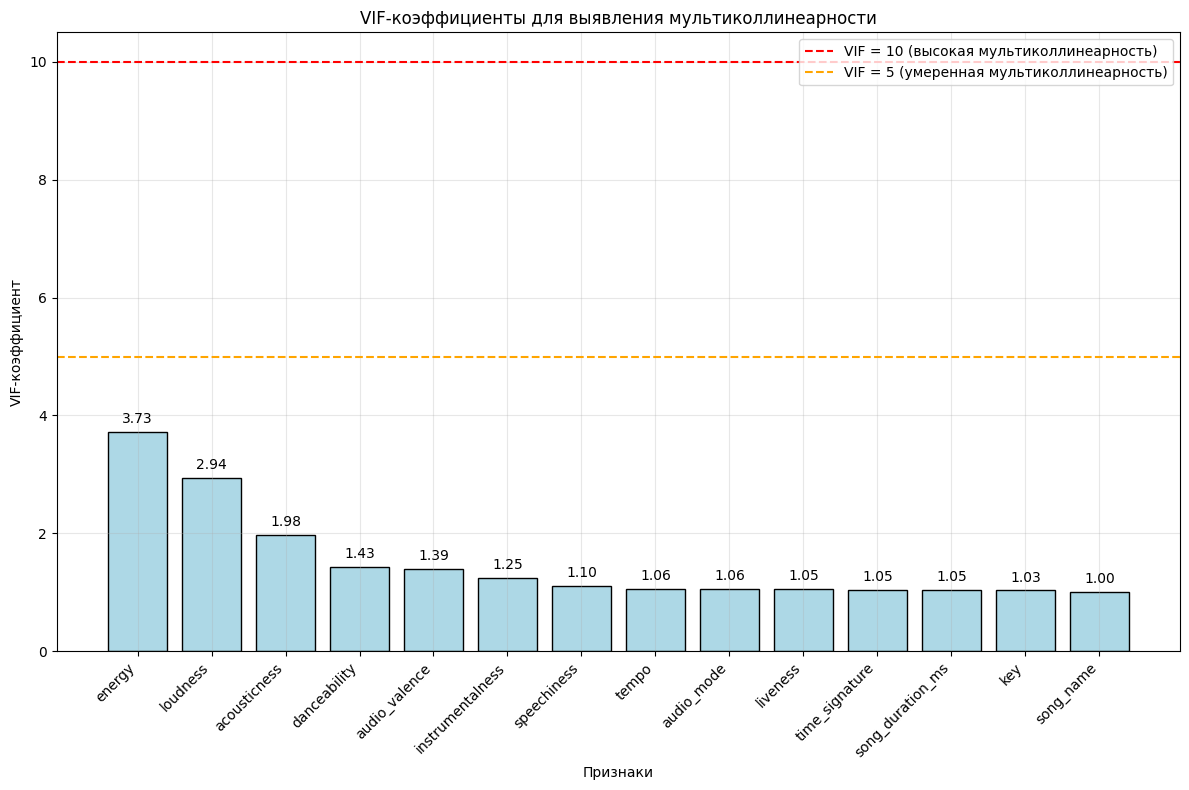

In [ ]:
# Визуализация VIF-коэффициентов
plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(vif_df)), vif_df['VIF'], color='lightblue', edgecolor='black')
plt.axhline(y=10, color='red', linestyle='--', label='VIF = 10 (высокая мультиколлинеарность)')
plt.axhline(y=5, color='orange', linestyle='--', label='VIF = 5 (умеренная мультиколлинеарность)')

plt.xlabel('Признаки')
plt.ylabel('VIF-коэффициент')
plt.title('VIF-коэффициенты для выявления мультиколлинеарности')
plt.xticks(range(len(vif_df)), vif_df['Признак'], rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

# Добавляем значения VIF на столбцы
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{vif_df.iloc[i]["VIF"]:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
# Итоговые выводы и рекомендации
print("="*60)
print("ИТОГОВЫЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ")
print("="*60)

print("\n1. ПРЕДОБРАБОТКА ДАННЫХ:")
print(f"   - Исходный размер датасета: {df.shape}")
print(f"   - Размер после удаления пропущенных значений: {df_processed.shape}")
print(f"   - Количество удаленных строк: {df.shape[0] - df_processed.shape[0]}")

print("\n2. КАТЕГОРИАЛЬНЫЕ ПЕРЕМЕННЫЕ:")
if categorical_columns:
    print(f"   - Найдено категориальных переменных: {len(categorical_columns)}")
    for col in categorical_columns:
        print(f"   - {col}: {df_processed[col].nunique()} уникальных значений")
else:
    print("   - Категориальных переменных не найдено")

print("\n3. НОРМАЛИЗАЦИЯ:")
print(f"   - Нормализовано признаков: {len(numeric_features)}")
print("   - Применен StandardScaler (среднее=0, стандартное отклонение=1)")

print("\n4. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:")
print("   - Построена матрица корреляций между всеми признаками")
print("   - Выявлены наиболее коррелирующие с целевой переменной признаки")

print("\n5. АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ:")
high_vif_count = len(vif_df[vif_df['VIF'] >= 10])
moderate_vif_count = len(vif_df[(vif_df['VIF'] >= 5) & (vif_df['VIF'] < 10)])
low_vif_count = len(vif_df[vif_df['VIF'] < 5])

print(f"   - Признаков с высокой мультиколлинеарностью (VIF ≥ 10): {high_vif_count}")
print(f"   - Признаков с умеренной мультиколлинеарностью (5 ≤ VIF < 10): {moderate_vif_count}")
print(f"   - Признаков без мультиколлинеарности (VIF < 5): {low_vif_count}")

if high_vif_count > 0:
    print("\n   РЕКОМЕНДАЦИИ:")
    print("   - Рассмотрите удаление признаков с VIF ≥ 10")
    print("   - Используйте методы регуляризации (Ridge, Lasso)")
    print("   - Примените PCA для снижения размерности")

print("\n6. ГОТОВНОСТЬ ДАННЫХ:")
print("   - Данные готовы для построения моделей машинного обучения")
print("   - Все признаки нормализованы и закодированы")
print("   - Выполнен анализ качества данных")


ИТОГОВЫЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ

1. ПРЕДОБРАБОТКА ДАННЫХ:
   - Исходный размер датасета: (18835, 15)
   - Размер после удаления пропущенных значений: (18835, 15)
   - Количество удаленных строк: 0

2. КАТЕГОРИАЛЬНЫЕ ПЕРЕМЕННЫЕ:
   - Найдено категориальных переменных: 1
   - song_name: 13070 уникальных значений

3. НОРМАЛИЗАЦИЯ:
   - Нормализовано признаков: 14
   - Применен StandardScaler (среднее=0, стандартное отклонение=1)

4. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:
   - Построена матрица корреляций между всеми признаками
   - Выявлены наиболее коррелирующие с целевой переменной признаки

5. АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ:
   - Признаков с высокой мультиколлинеарностью (VIF ≥ 10): 0
   - Признаков с умеренной мультиколлинеарностью (5 ≤ VIF < 10): 0
   - Признаков без мультиколлинеарности (VIF < 5): 14

6. ГОТОВНОСТЬ ДАННЫХ:
   - Данные готовы для построения моделей машинного обучения
   - Все признаки нормализованы и закодированы
   - Выполнен анализ качества данных
